# Backtest -- Different Portfolio Strategies
## Objectives
1. Backtest the Global Minimum Variance Portfolio or any other portfolio on the Efficient Frontier like maximum sharpe ratio portfolio

In [70]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sys
sys.path.insert(0, 'python_files')
import functions_1 as fnc
import edhec_risk_kit_127 as erk

r = fnc.local_returns_data()
rm = fnc.change_timeframe(r.dropna(), 'M')
er = fnc.annualize_returns(rm, 12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
cov = rm.cov()

Let's create a backtesting function which is capable of backtesting all three types of portfolios Maximum Sharpe Ratio (MSR), Global Minimum Variance (GMV), and Equally Weighted (EW)

In [41]:
def backtest_portfolio(returns, portfolio_type, periods_per_year, starting_balance, starting_step=None, rolling_period=0, weights_column=False,
                       riskfree_rate=0, weight_constraints=1, reweight_period=1, target_return=None,  *args, **kwargs):
    """
    Backtests different types of portfolios on a given set of returns and user-defined criteria.

    Parameters:
        returns (pd.DataFrame or pd.Series): A DataFrame or Series containing asset returns over time.
        portfolio_type (str): The type of portfolio to backtest ('GMV', 'MSR', 'TR', 'EW').
        periods_per_year (int): The number of periods in a year for the given returns dataset.
        starting_balance (float): The initial balance of the investment account.
        starting_step (int or None, optional): The number of starting rows to calculate the initial covariance matrix.
            Required for 'MSR', 'GMV', and 'TR' portfolios, optional for 'EW' portfolio.
        rolling_period (int, optional): The rolling period for calculating covariance matrix. Default is 0 (use all available data).
        weights_column (bool, optional): Whether to include a weight column in the resulting DataFrame. Default is False.
        riskfree_rate (float, optional): The risk-free rate used in calculating the MSR portfolio. Default is 0.
        weight_constraints (float, optional): Weight constraint for portfolio optimization. Default is 1.
        reweight_period (int, optional): The period after which to update the covariance matrix and expected returns.
            Default is 1 (update every period).
        target_return (float or None, optional): Required for 'TR' portfolio. The targeted return for the portfolio.

    Returns:
        pd.DataFrame: A DataFrame containing account value, returns, drawdowns, and optionally weights (if 'weights_column' is True).

    Note:
        The function supports backtesting of four portfolio types: 'GMV' (Global Minimum Variance), 'MSR' (Maximum Sharpe Ratio),
        'TR' (Targeted Return), and 'EW' (Equally Weighted).
    """
    if starting_step is None and (portfolio_type =='MSR' or portfolio_type == 'GMV' or portfolio_type == 'TR'):
        raise ValueError(f"Starting point cannot be None for {portfolio_type}")
    if portfolio_type not in ['EW', 'MSR', 'GMV', 'TR']:
        raise ValueError(f"{portfolio_type} is not a valid portfolio type")
    if portfolio_type == 'TR' and target_return is None:
        raise ValueError("target_return cannot be None for Targeted Return Portfolio (TR)")
    dates = returns.index
    num_steps = len(dates)
    account_value = starting_balance
    if isinstance(returns, pd.Series):
        returns = pd.DataFrame(returns, columns=['R'])
    account_history = pd.DataFrame(index=dates)
    account_history[f'Account Value {portfolio_type}'] = None
    if weights_column:
        account_history['Weights'] = None
    n_col = len(returns.columns)
    weights = np.repeat(1/10000000000, n_col)
    prev_cov = None
    prev_expected_rets = None
    for step in range(num_steps):
        if starting_step is not None and step >= starting_step and step >= rolling_period and step % reweight_period == 0:
            if rolling_period > 0:
                cov = returns.iloc[step - rolling_period + 1:step + 1].cov()
                expected_rets = fnc.annualize_returns(returns.iloc[step - rolling_period + 1:step + 1], periods_per_year)
                prev_cov = cov
                prev_expected_rets = expected_rets
            else:
                if prev_cov is not None and prev_expected_rets is not None:
                    cov = returns.iloc[:step].cov()
                    expected_rets = fnc.annualize_returns(returns.iloc[:step], periods_per_year)
                    prev_cov
                    prev_expected_rets = expected_rets
                else:
                    # Handle the case when no previous values are available yet
                    cov = returns.iloc[:step].cov()
                    if len(returns.iloc[:step]) < 1:
                        expected_rets = fnc.annualize_returns(returns.iloc[:step + 1], periods_per_year)
                    else:
                        expected_rets = fnc.annualize_returns(returns.iloc[:step], periods_per_year)
                    prev_cov = cov
                    prev_expected_rets = expected_rets

            if portfolio_type == 'GMV':
                weights = fnc.gmv(cov, weight_constraints=weight_constraints)
            elif portfolio_type == 'MSR':
                weights = fnc.msr(riskfree_rate, expected_rets, cov, weight_constraints).loc[0, 'Weights']
            elif portfolio_type == 'TR':
                weights = fnc.minimize_vol(target_return, er, cov, weight_constraints=weight_constraints)
            elif portfolio_type == 'EW':
                n = len(returns.columns)
                weights = np.repeat(1/n, n)

        portfolio_returns = fnc.portfolio_return(weights, returns.iloc[step])
        account_value *= 1 + portfolio_returns

        account_history[f'Account Value {portfolio_type}'].iloc[step] = account_value
        if weights_column:
            account_history['Weights'].iloc[step] = weights
    dr = fnc.drawdown(account_history[[f'Account Value {portfolio_type}']].pct_change())
    backtest_result = {
        'Returns': account_history[f'Account Value {portfolio_type}'].pct_change(),
        f'Account History {portfolio_type}': account_history[f'Account Value {portfolio_type}'],
        'Drawdown': dr[f'Account Value {portfolio_type}', 'Drawdown'],
        'Previous Peak': dr[f'Account Value {portfolio_type}', 'Previous Peak']
    }
    df = pd.DataFrame(backtest_result)
    if weights_column:
        df['Weights'] = account_history['Weights']
    if starting_step != 1:
        if starting_step > rolling_period:
            df = df.iloc[starting_step:]
        else:
            df = df.iloc[rolling_period:]
    return df


In [4]:
ew = backtest_portfolio(r.dropna(), 'EW', 252, 1000, weights_column=True, starting_step=1)
msr = backtest_portfolio(r.dropna(), 'MSR', 252, 1000, weights_column=True, starting_step=90, reweight_period=90)
gmv = backtest_portfolio(r.dropna(), 'GMV', 252, 1000, weights_column=True, starting_step=90, reweight_period=90)
tr8 = backtest_portfolio(r.dropna(), 'TR', 252, 1000, weights_column=True, starting_step=90, reweight_period=90, target_return=0.08)

c:\Users\user\miniconda3\envs\Data_Science_1\lib\site-packages\pandas\core\frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
c:\Users\user\miniconda3\envs\Data_Science_1\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\user\miniconda3\envs\Data_Science_1\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


<Axes: title={'center': 'Equally Weighted Portfolio Performances'}, xlabel='Date'>

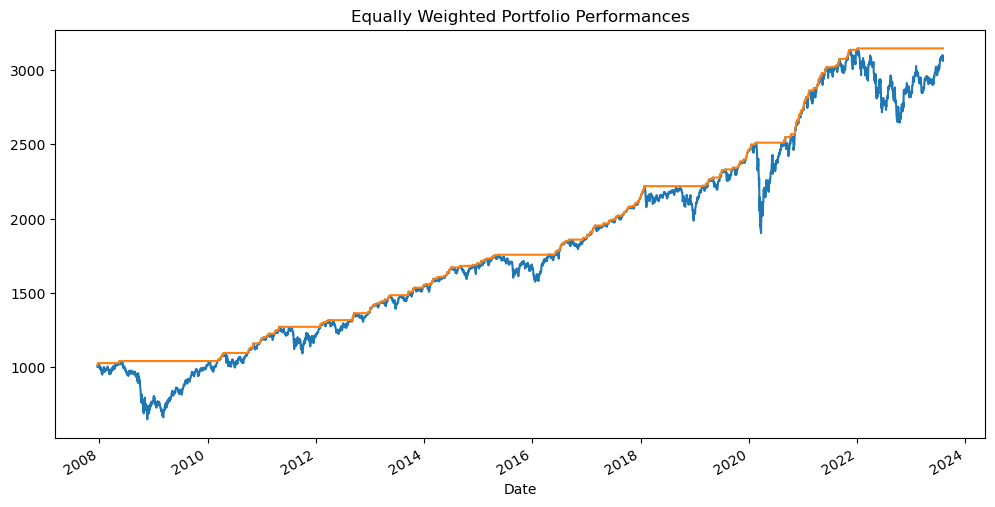

In [5]:
ax = ew['Account History EW'].plot(figsize=(12,6), title='Equally Weighted Portfolio Performances')
ew['Previous Peak'].plot(ax=ax)

<Axes: title={'center': 'Maximum Sharpe Ratio Portfolio Performances'}, xlabel='Date'>

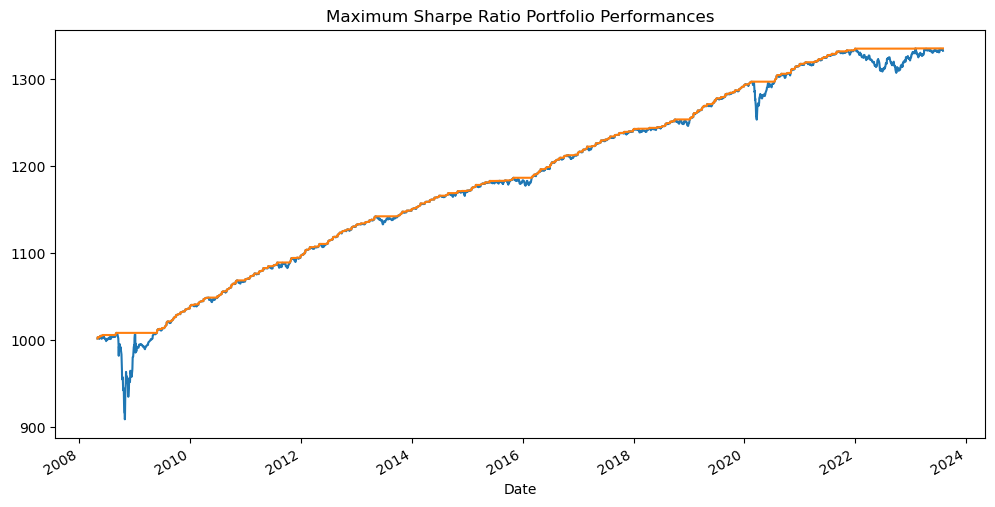

In [6]:
ax = msr['Account History MSR'].plot(figsize=(12,6), title='Maximum Sharpe Ratio Portfolio Performances')
msr['Previous Peak'].plot(ax=ax)

<Axes: title={'center': 'Global Minimum Variance Portfolio Performances'}, xlabel='Date'>

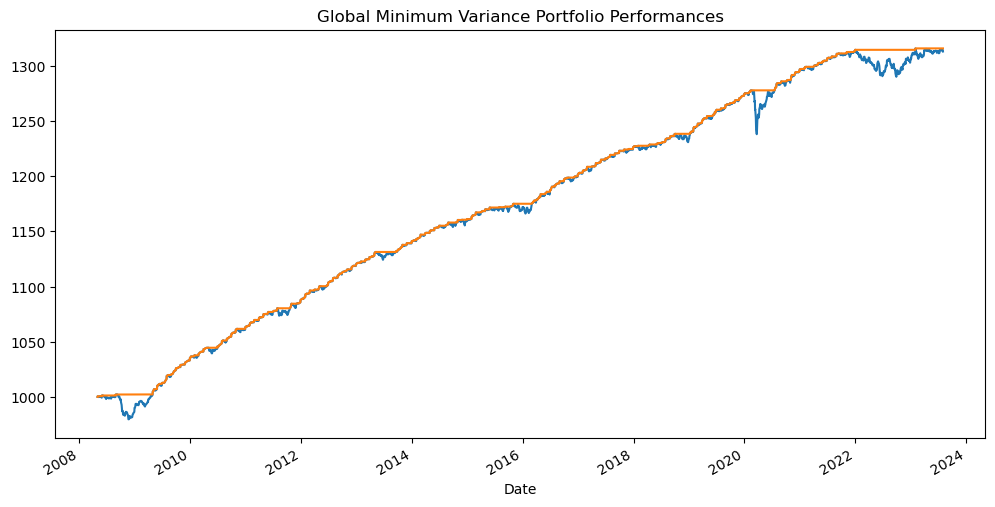

In [7]:
ax = gmv['Account History GMV'].plot(figsize=(12,6), title='Global Minimum Variance Portfolio Performances')
gmv['Previous Peak'].plot(ax=ax)

<Axes: title={'center': 'Target Return 8% Portfolio Performance'}, xlabel='Date'>

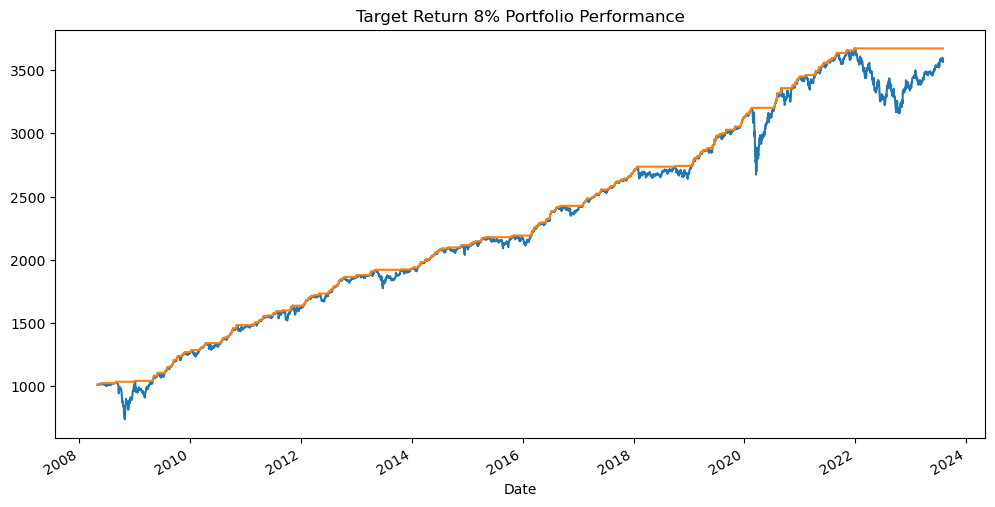

In [8]:
ax = tr8['Account History TR'].plot(figsize=(12,6), title='Target Return 8% Portfolio Performance')
tr8['Previous Peak'].plot(ax=ax)

### Summary Statistics for returns

In [9]:

def summary_stats(returns, periods_per_year, riskfree_rate=0):
    """
    Returns a summary stats for all the columns in returns
    """
    ann_r = returns.aggregate(fnc.annualize_returns, periods_per_year=periods_per_year)
    ann_vol = returns.aggregate(fnc.annualize_vol, periods_per_year=periods_per_year)
    ann_sr = returns.aggregate(fnc.sharpe_ratio, periods_per_year=periods_per_year, riskfree_rate=riskfree_rate)
    dd = returns.aggregate(lambda returns: fnc.drawdown(returns).Drawdown.min())
    skew = returns.aggregate(fnc.skewness)
    kurt = returns.aggregate(fnc.kurtosis)
    cf_var5 = returns.aggregate(fnc.var_gaussian, modified=True)
    hist_cvar = returns.aggregate(fnc.cvar_historic)
    df =  pd.DataFrame({
        'Annualized Returns': ann_r,
        'Annualized Vol': ann_vol,
        'Skewness': skew,
        'Kurtosis': kurt,
        'Cornish-Fisher VaR (5%)': cf_var5,
        'Historic Cvar (5%)': hist_cvar,
        'Sharpe Ratio': ann_sr,
        'Max Drawdown': dd
    })
    df['start dates'] = fnc.start_dates(returns)
    df['end dates'] = returns.index[-1]
    df['Time Period'] = df['start dates'] - df['end dates']
    df = df.drop(columns=['start dates', 'end dates'])
    return df

In [10]:
def weights_change(weights, columns,  *args, **kwargs):
    """
    Returns a Dataframe which contains the assets as columns and weights as rows on a particular time period

    Parameters:
        weights(pd.DataFrame, pd.Series): Weights Series or Dataframe
        columns(pandas.index, optional): To name the columns in the resulted dataframe    
    Returns:
        pd.DataFrame: A Dataframe containing the given columns as columns and their corresponding weights on each particular instant
    """
    if isinstance(weights, pd.Series):
        weights = pd.DataFrame(weights)
    weights_df = pd.DataFrame(columns=columns)
    for date in weights.index:
        weight = weights.loc[date]
        weights_df.loc[date] = weight.values[0]
    
    return weights_df


In [48]:
def combined_backtesting_result(r, portfolios, periods_per_year, rolling_period=0, riskfree_rate=0, weight_constraints=1,
                                 reweight_period=1, starting_step=None, target_returns=None, weights_column=False, starting_balance=1000, *args, **kwargs):
    """
    Combine and analyze backtesting results for multiple portfolios.

    This function calculates and combines the backtesting results for a list of portfolios, such as 
    Equally Weighted (EW), Maximum Sharpe Ratio (MSR), Global Minimum Variance (GMV), and Target 
    Returns (TR) portfolios.

    Parameters:
       r (pd.DataFrame or pd.Series): Returns dataset.
       portfolios (list): List of portfolio types ('MSR', 'EW', 'GMV', 'TR').
       periods_per_year (int): Number of periods in a year for the given returns dataset.
       rolling_period (int, optional): Rolling period for calculating covariance matrix. Default is 0 (use all available data).
       riskfree_rate (float, optional): Risk-free rate used in calculating the MSR portfolio. Default is 0.
       weight_constraints (float, optional): Weight constraint for portfolio optimization. Default is 1.
       reweight_period (int, optional): Period after which to update the covariance matrix and expected returns.
            Default is 1 (update every period).
       starting_step (int or None, optional): Number of starting rows to calculate the initial covariance matrix.
            Required for 'MSR', 'GMV', and 'TR' portfolios, optional for 'EW' portfolio.
       target_returns (list or float, optional): List of target returns for TR portfolio or a float for a single target return.
       weights_column (bool, optional): Include a weight column in the resulting DataFrame. Default is False.
       starting_balance (float, optional): Initial balance of the investment account. Default is 1000
       *args, **kwargs: Additional arguments.

    Returns:
       pd.DataFrame: A multiindex DataFrame containing portfolio types as main columns and backtesting
       results (returns, account history, drawdowns, etc.) as subcolumns.
    """
    if 'TR' in portfolios:
        portfolio_names = {
        'EW': ['Equally Weighted'],
        'MSR': ['Maximum Sharpe Ratio'],
        'GMV': ['Global Minimum Variance'],
        'TR': [f'Target Returns {target_return*100}%' for target_return in target_returns]
    }
    else:
        portfolio_names = {
        'EW': ['Equally Weighted'],
        'MSR': ['Maximum Sharpe Ratio'],
        'GMV': ['Global Minimum Variance']
        }

    if 'TR' in portfolios and target_returns is None:
        raise ValueError("target_returns cannot be None for Target Returns Portfolio (TR)")
    invalid_portfolios = [p for p in portfolios if p not in portfolio_names.keys()]
    if invalid_portfolios:
        raise ValueError(f"{invalid_portfolios} are not valid portfolio types")
    column_names = []
    for portfolio in portfolios:
        column_names.extend(portfolio_names[portfolio])
    
    portfolio_dfs = []

    for portfolio in portfolios:
        if portfolio != 'TR':
            df = backtest_portfolio(r, portfolio_type=portfolio, periods_per_year=periods_per_year, starting_balance=starting_balance, weights_column=weights_column,
                                    starting_step=starting_step, riskfree_rate=riskfree_rate, rolling_period=rolling_period, reweight_period=reweight_period,
                                    weight_constraints=weight_constraints)
            portfolio_dfs.append(df)
        else:
            for target_return in target_returns:
                df = backtest_portfolio(r, portfolio_type=portfolio, periods_per_year=periods_per_year, starting_balance=starting_balance, weights_column=weights_column,
                                    starting_step=starting_step, riskfree_rate=riskfree_rate, rolling_period=rolling_period, reweight_period=reweight_period,
                                    weight_constraints=weight_constraints, target_return=target_return)
                portfolio_dfs.append(df)

    # Combine all individual portfolio DataFrames into a single DataFrame
    result_df = pd.concat(portfolio_dfs, axis=1)

    # Create a MultiIndex for the columns
    multi_index = pd.MultiIndex.from_product([column_names, df.columns])
    result_df.columns = multi_index
    
    return result_df


In [64]:
step = 0.02
n = 5
start = 2
target_returns = [i*step for i in range(start, n+start)]
target_returns

[0.04, 0.06, 0.08, 0.1, 0.12]

In [71]:
comb_bct = combined_backtesting_result(rm, ['MSR', 'GMV', 'EW', 'TR'], periods_per_year=12, target_returns=target_returns, riskfree_rate=0.02, starting_step=36, reweight_period=3,
                                        weight_constraints=1, weights_column=True, rolling_period=36)

In [75]:
comb_bct.head()

Maximum Sharpe Ratio                                             \
                     Returns Account History TR  Drawdown Previous Peak   
Date                                                                      
2010-12             0.019889        1019.888894  0.000000   1019.888894   
2011-01            -0.035383         983.802638 -0.035383   1019.888894   
2011-02             0.031156        1014.453699 -0.005329   1019.888894   
2011-03             0.017344        1032.048332  0.000000   1032.048332   
2011-04             0.045790        1079.305766  0.000000   1079.305766   

                                                            \
                                                   Weights   
Date                                                         
2010-12  [1.1210354132479255e-15, 6.280434429671499e-16...   
2011-01  [1.1210354132479255e-15, 6.280434429671499e-16...   
2011-02  [1.1210354132479255e-15, 6.280434429671499e-16...   
2011-03  [0.0, 4.6839752165743046e-15, 0.0, 9.331406737...   
2011-04  [0.0, 4.6839752165743046e-15, 0.0, 9.331406737...   

        Global Minimum Variance                                            \
                        Returns Account History TR Drawdown Previous Peak   
Date                                                                        
2010-12                0.002741        1002.741317      0.0   1002.741317   
2011-01                0.003442        1006.192501      0.0   1006.192501   
2011-02                0.002628         1008.83681      0.0   1008.836810   
2011-03                0.001710        1010.562403      0.0   1010.562403   
2011-04                0.003073        1013.667706      0.0   1013.667706   

                                                            ...  \
                                                   Weights  ...   
Date                                                        ...   
2010-12  [0.9999999999985892, 2.510353036555557e-13, 5....  ...   
2011-01  [0.9999999999985892, 2.510353036555557e-13, 5....  ...   
2011-02  [0.9999999999985892, 2.510353036555557e-13, 5....  ...   
2011-03  [0.9999999999972726, 4.703598621702554e-13, 1....  ...   
2011-04  [0.9999999999972726, 4.703598621702554e-13, 1....  ...   

        Target Returns 10.0%                                            \
                     Returns Account History TR Drawdown Previous Peak   
Date                                                                     
2010-12             0.054053        1054.052773      0.0   1054.052773   
2011-01             0.017712        1072.722331      0.0   1072.722331   
2011-02             0.026391        1101.032453      0.0   1101.032453   
2011-03             0.004815        1106.333699      0.0   1106.333699   
2011-04             0.022067        1130.747264      0.0   1130.747264   

                                                            \
                                                   Weights   
Date                                                         
2010-12  [8.637474407769094e-18, 1.6106293348774323e-16...   
2011-01  [8.637474407769094e-18, 1.6106293348774323e-16...   
2011-02  [8.637474407769094e-18, 1.6106293348774323e-16...   
2011-03  [8.149769110342996e-15, 1.385232616371357e-17,...   
2011-04  [8.149769110342996e-15, 1.385232616371357e-17,...   

        Target Returns 12.0%                                            \
                     Returns Account History TR Drawdown Previous Peak   
Date                                                                     
2010-12             0.054053        1054.052773      0.0   1054.052773   
2011-01             0.017712        1072.722331      0.0   1072.722331   
2011-02             0.026391        1101.032453      0.0   1101.032453   
2011-03             0.004815        1106.333699      0.0   1106.333699   
2011-04             0.022067        1130.747264      0.0   1130.747264   

                                                            
            

In [76]:
comb_rets = comb_bct.xs('Returns', level=1, axis=1)
comb_weights = comb_bct.xs('Weights', level=1, axis=1)

In [79]:
summary_stats(comb_rets, 12, 0.02)

,Annualized Returns,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic Cvar (5%),Sharpe Ratio,Max Drawdown,Time Period
Maximum Sharpe Ratio,0.083048,0.087894,-0.130631,3.935983,0.035062,0.048924,0.704368,-0.185193,<-152 * MonthEnds>
Global Minimum Variance,0.016824,0.009763,-1.440136,11.295561,0.003795,0.005998,-0.319459,-0.017464,<-152 * MonthEnds>
Equally Weighted,0.083220,0.094439,-0.500073,4.594548,0.040502,0.059641,0.657326,-0.155080,<-152 * MonthEnds>
Target Returns 4.0%,0.034042,0.027432,-0.664702,6.403771,0.011042,0.016021,0.502654,-0.058118,<-152 * MonthEnds>
Target Returns 6.0%,0.049597,0.044615,-0.505345,5.803651,0.018047,0.026063,0.651434,-0.095102,<-152 * MonthEnds>
Target Returns 8.0%,0.064791,0.062807,-0.471722,5.448556,0.025771,0.036866,0.700290,-0.131327,<-152 * MonthEnds>
Target Returns 10.0%,0.124993,0.112239,-0.445608,3.555317,0.046343,0.066840,0.918586,-0.194157,<-152 * MonthEnds>
Target Returns 12.0%,0.124993,0.112239,-0.445606,3.555307,0.046343,0.066840,0.918587,-0.194155,<-152 * MonthEnds>
